In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/CAR%20PRICE%20PREDICTION/Car_dataset.csv')
df.drop(columns=['ID', 'Manufacturer', 'Model'], axis=1, inplace=True)
df.shape

(19237, 13)

### Analysing the price column (target column)

In [3]:
df['Price'].describe()

count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64

#### To handle the multivariate outliers in the Price column we need clean the other columns as well which affects the price column 

In [5]:
df.columns

Index(['Price', 'Levy', 'year', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Cylinders', 'Gear type', 'Wheel', 'Color',
       'Airbags'],
      dtype='object')

### Cleaning the "Engine Volume' Column

In [4]:
# 1. FIRST: Create the 'Engine Type' column using the original string values
df['Engine Type'] = df['Engine volume'].apply(lambda x: 1 if 'Turbo' in str(x) else 0)

# 2. SECOND: Now clean the 'Engine volume' column by removing 'Turbo' and converting# Split the string by space and take the first part, then convert to float
df['Engine volume'] = df['Engine volume'].str.split().str[0].astype(float)

<Figure size 1200x600 with 0 Axes>

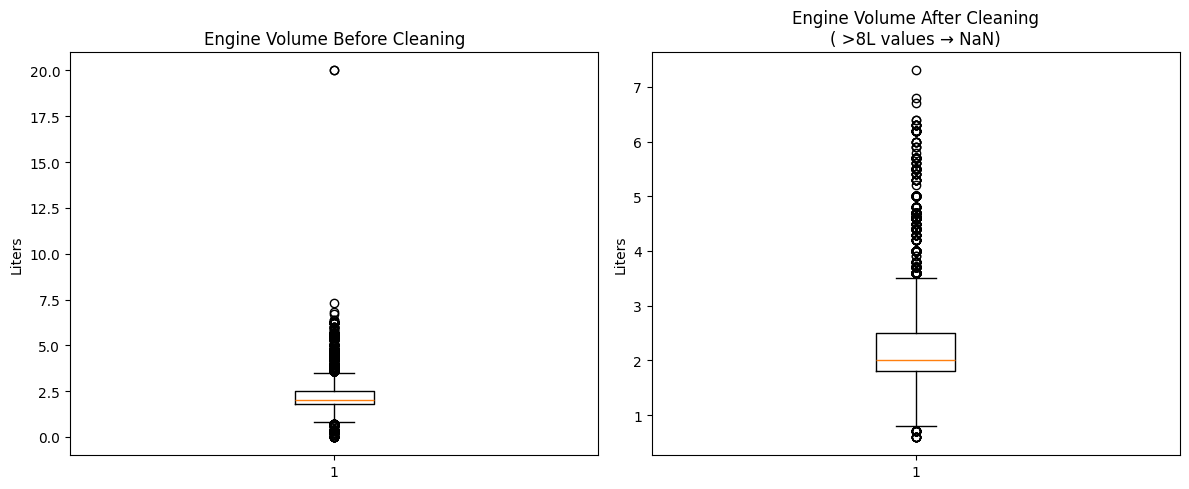

In [5]:
plt.figure(figsize=(12, 6))

# Create subplots for before/after comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Store original data for plotting

# Plot 1: Before cleaning
ax1.boxplot(df['Engine volume'])
ax1.set_title('Engine Volume Before Cleaning')
ax1.set_ylabel('Liters')

# Clean the data (properly)
df.loc[(df['Engine volume'] > 8) | (df['Engine volume'] < 0.6), 'Engine volume'] = np.nan

# Plot 2: After cleaning
ax2.boxplot(df['Engine volume'][df['Engine volume'].notna()])
ax2.set_title('Engine Volume After Cleaning\n( >8L values → NaN)')
ax2.set_ylabel('Liters')

plt.tight_layout()
plt.show()

In [6]:
# Filling the missing values in # Group by 'Cylinders' and fill missing 'Engine volume' with the median of that group
df['Engine volume'] = df.groupby('Cylinders')['Engine volume'].transform(
    lambda x: x.fillna(x.median())
)

# If there are any remaining NaNs (groups with no data), fill with overall median
df['Engine volume'] = df['Engine volume'].fillna(df['Engine volume'].median())


In [7]:
df['Engine volume'].describe()

count    19237.000000
mean         2.311150
std          0.853073
min          0.600000
25%          1.800000
50%          2.000000
75%          2.500000
max          7.300000
Name: Engine volume, dtype: float64

In [8]:
# Making the Gear Type column more to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['Gear type'], drop_first=False)

df = df.astype({col: 'int' for col in df.filter(like='Gear type').columns})     # Makes the one-hot encoded columns to int type

In [9]:
# Converting the 'Leather interior' column to binary
df['Leather interior'] = df['Leather interior'].apply(lambda x: 1 if x == 'Yes' else 0)

# Converting the 'Wheel' column to binary
df['Wheel'] = df['Wheel'].apply(lambda x: 1 if x == 'Left wheel' else 0)

### Cleaning the mileage column

In [10]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

# Count how many rows have the absurd maximum value
absurd_value = 2147483647
absurd_count = (df['Mileage'] == absurd_value).sum()
print(f"Number of rows with absurd mileage ({absurd_value}): {absurd_count}")
print(f"Percentage of total data: {(absurd_count / len(df)) * 100:.2f}%")

# Also, check for other very high values (e.g., over 1,000,000 km)
unreal_mileage = (df['Mileage'] < 100) | (df['Mileage'] > 500000).sum()
print(f"Number of rows with unrealistic mileage: {unreal_mileage}")
original_shape = df.shape

df.loc[(df['Mileage'] < 100) | (df['Mileage'] > 500000), 'Mileage'] = np.nan

print(f"Shape before cleaning: {original_shape}")
print(f"Shape after cleaning: {df.shape}")  # The shape should be THE SAME
print(f"Number of unrealistic mileage values converted to NaN: {df['Mileage'].isna().sum()}")

Number of rows with absurd mileage (2147483647): 7
Percentage of total data: 0.04%
Number of rows with unrealistic mileage: 0        True
1        True
2        True
3        True
4        True
         ... 
19232    True
19233    True
19234    True
19235    True
19236    True
Name: Mileage, Length: 19237, dtype: bool
Shape before cleaning: (19237, 17)
Shape after cleaning: (19237, 17)
Number of unrealistic mileage values converted to NaN: 983


In [11]:
# Group by relevant columns and fill NaN with the mode (most common value) of that group
df['Mileage'] = df.groupby(['Engine volume', 'Cylinders', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type'])['Mileage'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Mileage'].mode()[0])
)

# Check if there are any remaining NaNs and fill with overall mode
if df['Mileage'].isna().sum() > 0:
    overall_mode = df['Mileage'].mode()
    if not overall_mode.empty:
        df['Mileage'] = df['Mileage'].fillna(overall_mode[0])
        
        
df['Mileage'].describe()

count     19237.000000
mean     138765.511410
std       87588.904256
min         102.000000
25%       74500.000000
50%      128000.000000
75%      186542.000000
max      500000.000000
Name: Mileage, dtype: float64

<Axes: xlabel='Mileage', ylabel='Density'>

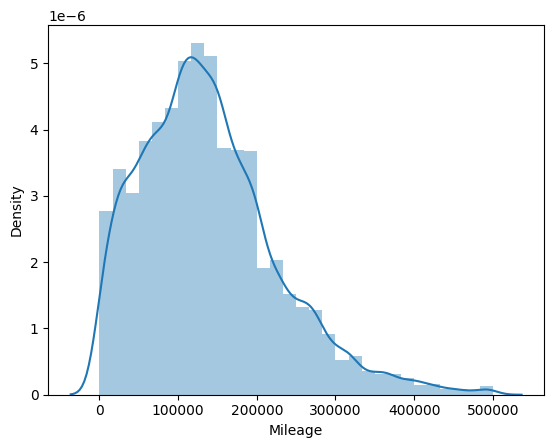

In [12]:
sns.distplot(df['Mileage'], bins=30, kde=True)

In [13]:
df['Cylinders'].describe()

df[df['Cylinders'] < 3] = np.nan
print(f"Number of rows with unrealistic 'Cylinders' values (<3): {df['Cylinders'].isna().sum()}")

# Applying the same technique as i applied to the 'Mileage' column to fill these unusual 'Cylinders' values
df['Cylinders'] = df.groupby(['Engine volume', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type'])['Cylinders'].transform(
    lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x.fillna(df['Cylinders'].mode()[0])
)

Number of rows with unrealistic 'Cylinders' values (<3): 80


<Axes: xlabel='Cylinders', ylabel='Density'>

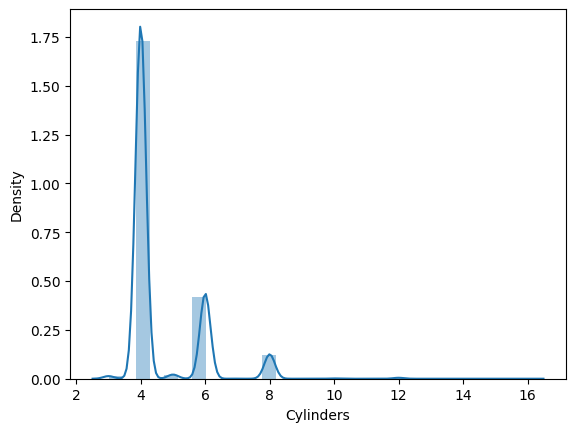

In [14]:
sns.distplot(df['Cylinders'], bins=30, kde=True)

In [15]:
df['Airbags'].describe()

count    19157.000000
mean         6.594717
std          4.317404
min          0.000000
25%          4.000000
50%          6.000000
75%         12.000000
max         16.000000
Name: Airbags, dtype: float64

In [20]:
df[df['Airbags'] == 0].shape

(2378, 17)

In [58]:
df.head()

,Price,Levy,year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Wheel,Color,Airbags,Engine Type,Gear type_Automatic,Gear type_Manual,Gear type_Tiptronic,Gear type_Variator
0,13328,1399,2010,Jeep,1,Hybrid,3.5,186005.0,6,1,Silver,12,0,1,0,0,0
1,16621,1018,2011,Jeep,0,Petrol,3.0,192000.0,6,1,Black,8,0,0,0,1,0
2,8467,-,2006,Hatchback,0,Petrol,1.3,200000.0,4,0,Black,2,0,0,0,0,1
3,3607,862,2011,Jeep,1,Hybrid,2.5,168966.0,4,1,White,0,0,1,0,0,0
4,11726,446,2014,Hatchback,1,Petrol,1.3,91901.0,4,1,Silver,4,0,1,0,0,0


<Axes: >

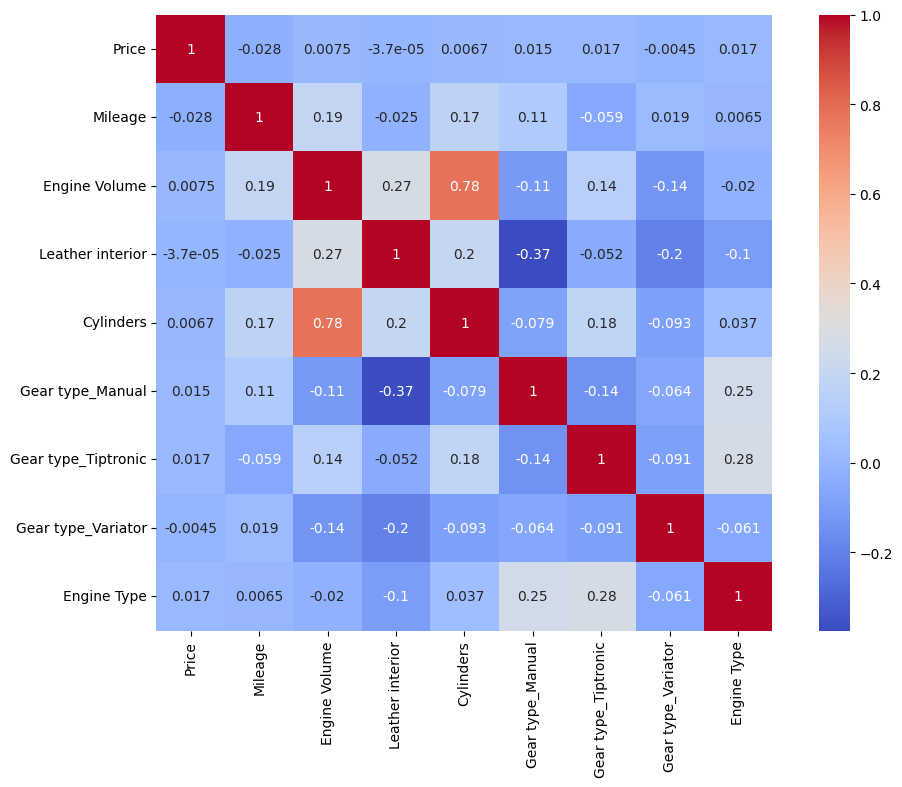

In [49]:
# Now Create a Correlation Heatmap to see how features are correlated with Price
import matplotlib.pyplot as plt

corr_df = df[df[['Price', 'Mileage', 'Engine Volume', 'Leather interior', 'Cylinders', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type']].columns]  # Select relevant columns for correlation
plt.figure(figsize=(12, 8))
correlation_matrix = corr_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

In [57]:
# Print percentage of price values less than the 25th percentile of the data
price_25th_percentile = df['Price'].quantile(0.25)
price_75th_percentile = df['Price'].quantile(0.75)
lower_lim = price_25th_percentile - (1.5*(price_75th_percentile - price_25th_percentile))
upper_lim = price_75th_percentile + (1.5*(price_75th_percentile - price_25th_percentile))

percentage_below_25th = (df['Price'] < lower_lim).mean() * 100
print(f"Percentage of Price values below the 25th percentile ({price_25th_percentile}): {percentage_below_25th:.2f}%")

percentage_above_75th = (df['Price'] > upper_lim).mean() * 100
print(f"Percentage of Price values above the 75th percentile ({price_75th_percentile}): {percentage_above_75th:.2f}%")

Percentage of Price values below the 25th percentile (5645.0): 0.00%
Percentage of Price values above the 75th percentile (22894.0): 5.39%


In [55]:
low_price_df = df[df['Price'] < price_25th_percentile][['year', 'Mileage', 'Engine Volume', 'Leather interior', 'Cylinders', 'Wheel', 'Gear type_Manual', 'Gear type_Tiptronic', 'Gear type_Variator', 'Engine Type']].copy()

low_price_df['Price'] = np.nan
low_price_df['Price']

3       NaN
6       NaN
7       NaN
8       NaN
10      NaN
         ..
19228   NaN
19229   NaN
19230   NaN
19235   NaN
19236   NaN
Name: Price, Length: 4446, dtype: float64

In [ ]:
low_price_df['Price'] = 

,Price,Levy,year,Category,Leather interior,Fuel type,Mileage,Cylinders,Wheel,Color,Airbags,Engine Volume,Engine Type,Gear type_Automatic,Gear type_Manual,Gear type_Tiptronic,Gear type_Variator
3,3607,862,2011,Jeep,1,Hybrid,168966,4,1,White,0,2.5,0,1,0,0,0
6,1803,761,2010,Hatchback,1,Hybrid,258909,4,1,White,12,1.8,0,1,0,0,0
7,549,751,2013,Sedan,1,Petrol,216118,4,1,Grey,12,2.4,0,1,0,0,0
8,1098,394,2014,Sedan,1,Hybrid,398069,4,1,Black,12,2.5,0,1,0,0,0
10,941,1053,2014,Sedan,1,Diesel,184467,6,1,White,12,3.5,0,1,0,0,0


In [29]:
numerical_cols = ['Price', 'Levy', 'year', 'Engine_volume_value', 'Mileage', 'Cylinders', 'Airbags']
categorical_cols = ['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear type', 'Wheel', 'Color']

(2322, 17)


<Axes: ylabel='Price'>

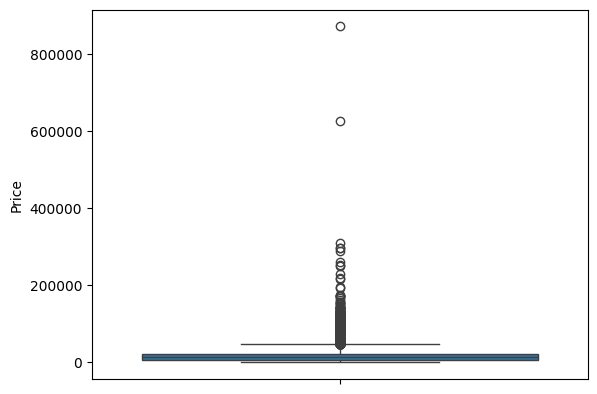

In [41]:
df.drop(df.loc[df['Price'] == 26307500.0].index, inplace=True)
df['Price'].describe()

print(df[df['Price'] < 800].shape)

sns.boxplot(y=df['Price'])

### Data Cleaning 

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots: 1 row, as many columns as categorical_cols
fig = make_subplots(rows=1, cols=len(categorical_cols),
                    subplot_titles=[f'{col}' for col in categorical_cols])

# Loop through categorical columns and add a subplot for each
for i, col in enumerate(categorical_cols):
    fig.add_trace(
        go.Bar(
            x=df[col].value_counts().index,
            y=df[col].value_counts().values
        ),
        row=1,
        col=i+1
    )

# Update layout
fig.update_layout(
    title='Distribution of Categorical Columns',
    template='plotly_dark',
    showlegend=False,
    width=400 * len(categorical_cols),   # 400px width per subplot
    height=500
)

fig.show()


#### Cleaning the levy column 

In [30]:
# Cleanign the leavy column & change the data type to int
df['Levy'] = df['Levy'].replace('-', np.nan)
df['Levy'] = df['Levy'].astype(float)

df['Levy'].isna().sum()

df['Levy_missing'] = df['Levy'].apply(lambda x: 1 if pd.isna(x) else 0)
df['Levy'].fillna(df['Levy'].median(), inplace=True)

# Plot the pltoly box plot to visualize outliers
fig = go.Figure()
fig.add_trace(go.Box(y=df['Levy'], name='Levy', boxpoints='outliers', jitter=0.5, pointpos=-1.8))
fig.update_layout(title='Box Plot of Levy', template='plotly_dark')
fig.show()

In [31]:
# Drop all the levy values over 5k
df.drop( df[df['Levy'] > 5000].index, inplace=True)

# Plot the pltoly box plot to visualize outliers
fig = go.Figure()
fig.add_trace(go.Box(y=df['Levy'], name='Levy', boxpoints='outliers', jitter=0.5, pointpos=-1.8))
fig.update_layout(title='Box Plot of Levy', template='plotly_dark')
fig.show()

In [32]:
Q3 = np.percentile(df['Levy'], 75)
IQR = np.percentile(df['Levy'], 75) - np.percentile(df['Levy'], 25)
upper_limit = Q3 + 1.5 * IQR
lower_limit = np.percentile(df['Levy'], 25) - 1.5 * IQR

percentile = np.sum(df['Levy'] > upper_limit) / len(df['Levy']) * 100
print(f'Percentage of data above the upper limit: {percentile:.2f}%')

# Create a flag column for the outliers 
df['Levy_flag'] = ~df['Levy'].between(lower_limit, upper_limit)

Percentage of data above the upper limit: 12.07%


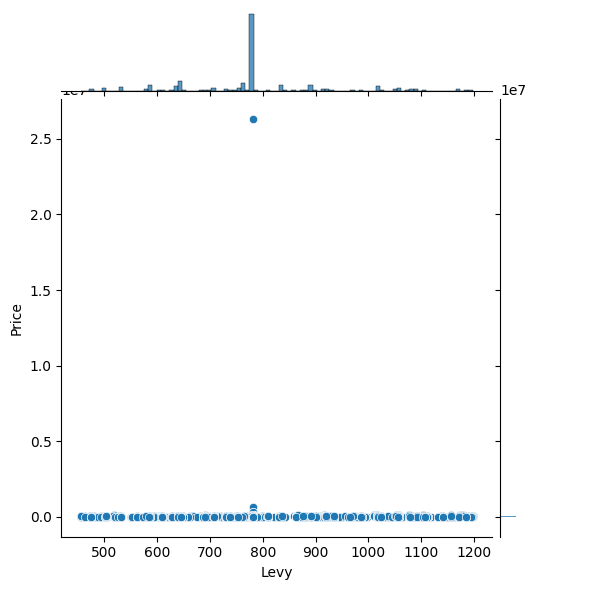

np.int64(26307500)

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

df_nf = df.loc[~df["Levy_flag"]].copy()

g = sns.jointplot(
    data=df_nf,
    x="Levy",
    y="Price",
    kind="scatter",       # or "hex", "kde", "reg"
    height=6,
    space=0.1
)
g.set_axis_labels("Levy", "Price")
plt.show()

df_nf['Price'].max()


In [8]:
df.head()

,ID,Price,Levy,Manufacturer,Model,year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear type,Wheel,Color,Airbags,Levy_missing
0,45654403,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6,Automatic,Left wheel,Silver,12,0
1,44731507,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6,Tiptronic,Left wheel,Black,8,0
2,45774419,8467,781.0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4,Variator,Right-hand drive,Black,2,0
3,45769185,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4,Automatic,Left wheel,White,0,0
4,45809263,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4,Automatic,Left wheel,Silver,4,0


In [11]:
# Cleaning the 'Mileage' column by removing 'km' and converting to integer
df['Mileage'] = df['Mileage'].str.replace('km', '').str.replace(',', '').astype(int)

In [ ]:
# Cleanig the 'Engine_volume' column by removing 'Turbo' and converting to integer
df['Engine_volume_value'] = df['Engine volume'].str.replace('Turbo', '').astype(float)
df['Enigine_type'] = df['Engine volume'].apply(lambda x: 'Turbo' if 'Turbo' in x else 'Non-Turbo')
df.drop('Engine volume', axis=1, inplace=True)

In [76]:
def remove_units(col):
    return str(col).split(' ')[0]  # Convert to string before splitting

def make_zero_nan(col):
    try:
        # First attempt to convert to integer
        int_val = int(col)
        # Return np.nan if zero, otherwise return the integer
        return np.nan if int_val == 0 else int_val
    except (ValueError, TypeError):
        # Return original value if conversion fails
        return col

def extract_types(col):
    if pd.isna(col):
        return (np.nan, np.nan)
    
    parts = str(col).split(' ')
    value = parts[0] if len(parts) > 0 else np.nan
    types = ' '.join(parts[1:]) if len(parts) > 1 else np.nan
    
    # Convert value to float if possible
    try:
        value = float(value)
    except (ValueError, TypeError):
        value = np.nan
        
    return (value, types)

def handle_hyphens(col):
    try:
        str_val = str(col).strip()  
        
        if str_val == '-':
            return np.nan
            
        return float(str_val)
    except (ValueError, TypeError):
        return np.nan  

In [77]:
# Cleaning The Mileage Column
df['Mileage'] = (
    df['Mileage']
    .apply(remove_units)
    .apply(make_zero_nan)
    .astype(float)
)

In [78]:
# Cleaning The Engine volume Column
df[['Engine_volume_value', 'Engine_volume_type']] = df['Engine volume'].apply(
    lambda x: pd.Series(extract_types(x))
)

df['Engine_volume_value'] = (
    df['Engine_volume_value']
    .apply(make_zero_nan)
    .astype(float)
)

df.drop('Engine volume', axis=1, inplace=True)

In [79]:
# Cleaning The Levy Column
df['Levy'] = df['Levy'].apply(handle_hyphens)

In [80]:
# Cleanign The Airbags Column as most of cars after 2000 installed airbags
df.loc[
    ((df['year'] > 2000) & (df['Airbags'] == 0)) |  # Condition 1: Any car post-2000 without airbags
    ((df['Manufacturer'] == 'MERCEDES-BENZ') & (df['year'] > 1991) & (df['Airbags'] == 0)),  # Condition 2: Mercedes post-1991 without airbags
    'Airbags'
] = np.nan

In [81]:
for cols in numerical_cols:
    print(f'Column name: {cols}\n{df[cols].describe()}', end='\n\n')

Column name: Price
count    1.923700e+04
mean     1.855593e+04
std      1.905813e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.207500e+04
max      2.630750e+07
Name: Price, dtype: float64

Column name: Levy
count    13418.000000
mean       906.838128
std        461.867051
min         87.000000
25%        640.000000
50%        781.000000
75%       1058.000000
max      11714.000000
Name: Levy, dtype: float64

Column name: year
count    19237.000000
mean      2010.912824
std          5.668673
min       1939.000000
25%       2009.000000
50%       2012.000000
75%       2015.000000
max       2020.000000
Name: year, dtype: float64

Column name: Engine_volume_value
count    19142.000000
mean         1.945617
std          0.910394
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         20.000000
Name: Engine_volume_value, dtype: float64

Column name: Mileage
count    1.851600e+04
mean     1.591900e+06
std      4.9336

### EDA 

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from warnings import filterwarnings
filterwarnings('ignore')

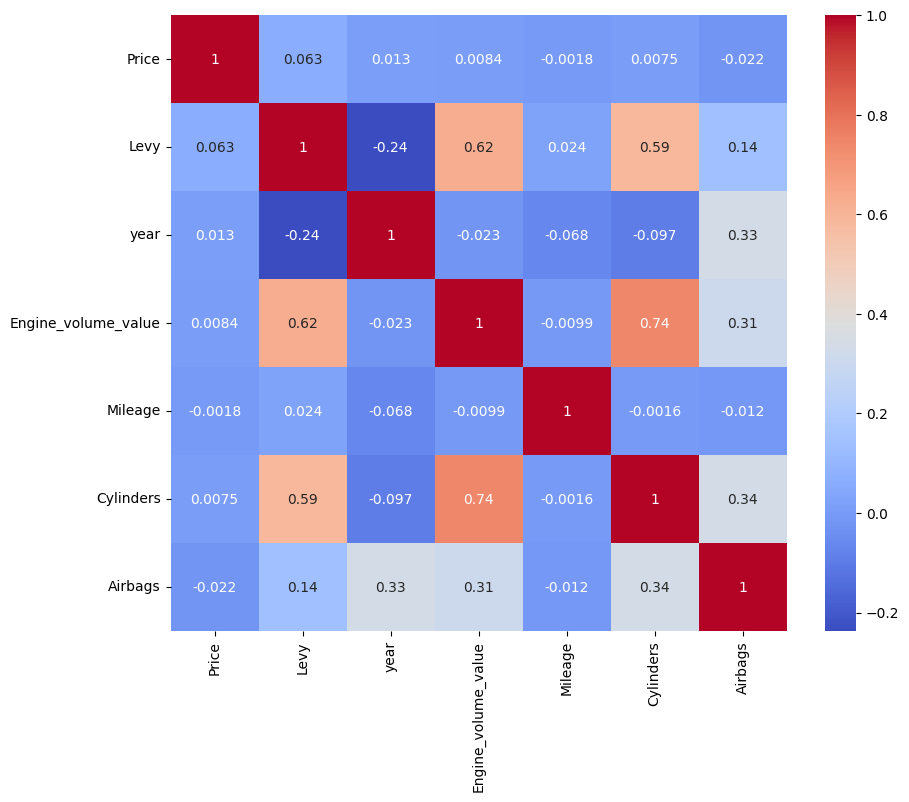

In [83]:
# calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)

# show the plot
plt.show()

##### Analysing the price column

In [84]:
df = df[(df['Price'] >= 2000) & (df['Price'] <= 500000)]

In [92]:
# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Box Plot", "PDF Plot"))

# Box plot
fig.add_trace(
    go.Box(
        x=df["Price"],
        boxpoints="outliers",  # Show outliers
        hoverinfo="text",
        hovertext=[f"Price: {price}" for price in df["Price"]]
    ),
    row=1, col=1
)

# Histogram (PDF-like plot)
fig.add_trace(
    go.Histogram(
        x=df["Price"],
        nbinsx=50
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title="Distribution of Price",
    template="plotly_dark"
)

fig.show()


In [87]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

outliers = (df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))
print(Q1, Q3, IQR)

9408.0 24920.0 15512.0
